# Time-Series Forecasting with Spiking Neural Network

## 1. Setup and Imports

Source `.venv/bin/python` as Jupiter Notebook kernel.

## 2. Load Configuration

## 3. Data Loading

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the dataset
file_path = "./dataset/LD2011_2014.txt"

# Read the dataset
df = pd.read_csv(file_path, sep=";", decimal=",")

# Get the time column (first column) and the first n data columns
df["time"] = pd.to_datetime(df["time"])

print(df.head())

                 time  MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
0 2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1 2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2 2011-01-01 00:45:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3 2011-01-01 01:00:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4 2011-01-01 01:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_008  MT_009  ...  MT_361  MT_362  MT_363  MT_364  MT_365  MT_366  \
0     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

   MT_367  MT_368  MT_369  MT_370  
0     0.0     0.0     0.0     0.

## 4. Data Visualization

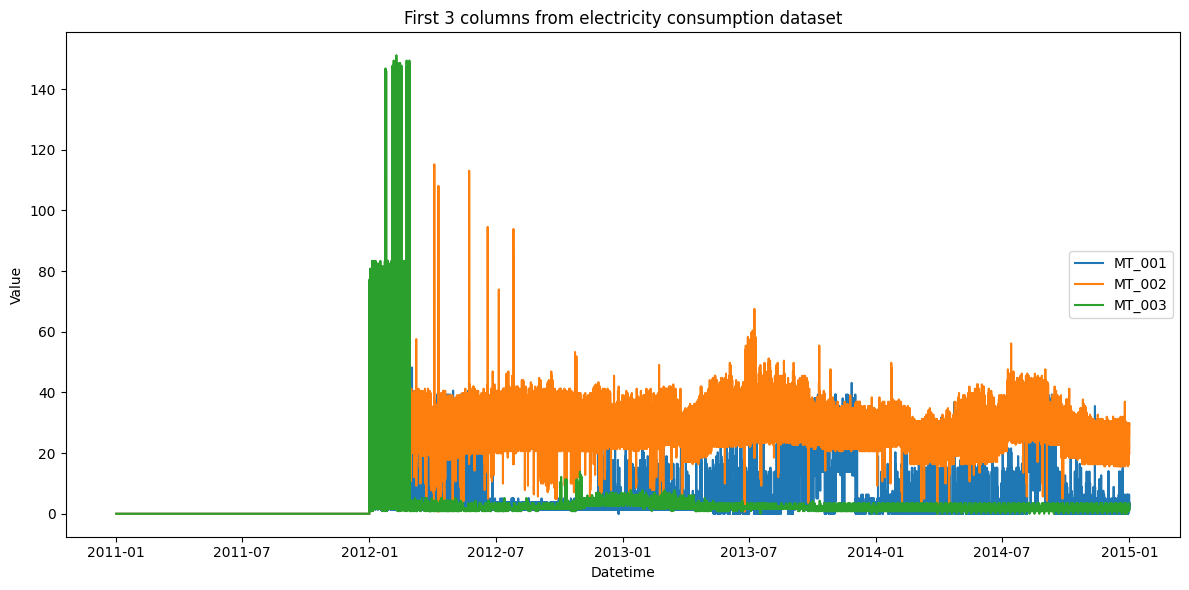

In [50]:
# How many of the first columns to plot
clients_to_plot = 3

# Plot
plt.figure(figsize=(12, 6))
df_to_plot = df.iloc[:, :clients_to_plot + 1]

for col in df_to_plot.columns:
    if col == "time":
        continue
    plt.plot(df_to_plot["time"], df_to_plot[col], label=col)

plt.xlabel("Datetime")
plt.ylabel("Value")
plt.title(f"First {clients_to_plot} columns from electricity consumption dataset")
plt.legend(loc='right')
plt.tight_layout()
plt.show()

## 5. Data Preprocessing

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df.iloc[:, 1:] = scaler.fit_transform(df.iloc[:, 1:])  #exclude the time column

def create_windows(data, window_size, split):
    windows = []
    for start in range(0, len(data) - window_size + 1):
        end = start + window_size
        window={
            'past': data[start:(start+split), 1:],  # Exclude the time column
            'future': data[(start+split):end, 1:]  # Exclude the time column 
        }
        windows.append(window)  # Exclude the time column
    print(f"Created {len(windows)} windows of size {window_size}")
    print(f"Past shape: {windows[0]['past'].shape}")
    print(f"Future shape: {windows[0]['future'].shape}")
    print(f"Sample window:\n{windows[100000]}")
    return windows

In [52]:
window_size = 64
split = 16

windows = create_windows(df.values, window_size=window_size, split=split)

Created 140193 windows of size 64
Past shape: (16, 370)
Future shape: (48, 370)
Sample window:
{'past': array([[0.28947368421052716, 0.2222222222222228, 0.01149425287356325,
        ..., 0.778801843317973, 0.6005679129200173, 0.7153846153846153],
       [0.3157894736842109, 0.2345679012345682, 0.01149425287356325, ...,
        0.8248847926267285, 0.5806909607193548, 0.738461538461538],
       [0.28947368421052716, 0.2345679012345682, 0.01149425287356325,
        ..., 0.8525345622119819, 0.5622337908187396, 0.7461538461538476],
       ...,
       [0.3157894736842109, 0.2716049382716053, 0.01149425287356325, ...,
        0.6820276497695861, 0.5991481306199701, 0.5615384615384632],
       [0.3421052631578946, 0.2839506172839516, 0.01149425287356325, ...,
        0.6451612903225816, 0.5929957406530979, 0.5923076923076923],
       [0.3421052631578946, 0.27777777777777807, 0.017241379310344838,
        ..., 0.6543778801843327, 0.5877898722195912, 0.5769230769230761]],
      dtype=object), 'f

In [53]:
import torch
from torch.utils.data import Dataset
import numpy as np

dtype = torch.float32
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"{device=}")

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.features = data["past"].values
        self.labels = data["future"].values
        self.transform = transform

        print(f"Dataset size: {len(self.features)} samples")
        print(f"Feature shape: {self.features[0].shape if len(self.features) > 0 else 'N/A'}")
        print(f"Label shape: {self.labels[0].shape if len(self.labels) > 0 else 'N/A'}")

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        
        feature = np.array(feature, dtype=np.float32)
        label = np.array(label, dtype=np.float32)
        sample = {'feature': torch.tensor(feature, dtype=dtype), 'label': torch.tensor(label, dtype=dtype)}
        return sample

    def __len__(self):
        return len(self.features)

device=device(type='cpu')


In [54]:
dataset = CustomDataset(pd.DataFrame(windows))

print(f"Total samples in dataset: {len(dataset)}")
print(f"Sample feature shape: {dataset[100000]['feature'].shape}")
print(f"Sample label shape: {dataset[100000]['label'].shape}")
print(f"Sample feature data:\n{dataset[100000]['feature']}")
print(f"Sample label data:\n{dataset[100000]['label']}")

Dataset size: 140193 samples
Feature shape: (16, 370)
Label shape: (48, 370)
Total samples in dataset: 140193
Sample feature shape: torch.Size([16, 370])
Sample label shape: torch.Size([48, 370])
Sample feature data:
tensor([[0.2895, 0.2222, 0.0115,  ..., 0.7788, 0.6006, 0.7154],
        [0.3158, 0.2346, 0.0115,  ..., 0.8249, 0.5807, 0.7385],
        [0.2895, 0.2346, 0.0115,  ..., 0.8525, 0.5622, 0.7462],
        ...,
        [0.3158, 0.2716, 0.0115,  ..., 0.6820, 0.5991, 0.5615],
        [0.3421, 0.2840, 0.0115,  ..., 0.6452, 0.5930, 0.5923],
        [0.3421, 0.2778, 0.0172,  ..., 0.6544, 0.5878, 0.5769]])
Sample label data:
tensor([[0.3158, 0.2901, 0.0115,  ..., 0.7051, 0.6148, 0.6308],
        [0.3421, 0.2778, 0.0115,  ..., 0.6544, 0.5973, 0.6154],
        [0.3421, 0.2716, 0.0115,  ..., 0.6406, 0.5774, 0.5923],
        ...,
        [0.3158, 0.2963, 0.0115,  ..., 0.3641, 0.4870, 0.6000],
        [0.2895, 0.2840, 0.0115,  ..., 0.3594, 0.5088, 0.5692],
        [0.3158, 0.2778, 0.0115, 

In [55]:
from torch.utils.data import DataLoader, random_split

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(
    dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Total dataset size: {total_size}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Total dataset size: 140193
Train dataset size: 98135
Validation dataset size: 21028
Test dataset size: 21030


## 6. Model Definition

## 7. Training

## 8. Training Visualization

## 9. Evaluation

## 10. Results Visualization

## 11. Save Results